# Stock Market Trend & Forecasting

This Jupyter notebook demonstrates how to analyse and forecast stock prices using data from **Yahoo Finance**.
The [**yfinance**](https://pypi.org/project/yfinance/) library provides a Pythonic way to download historical market data from Yahoo Finance【149823094445112†L105-L116】.  The data includes daily open, high, low, close and volume values for publicly traded securities.  

In this project we will:  
1. Download historical price data for a selected stock (e.g., **AAPL**) over a multi‑year period.  
2. Compute daily returns and rolling statistics (moving averages, volatility).  
3. Visualise price trends and returns.  
4. Fit a simple forecasting model (e.g., exponential smoothing or ARIMA) to predict future prices.  
5. Evaluate forecast performance and discuss investment insights.


In [1]:
# ============================================================
# 0. Reset yfinance installation (run this ONCE in a notebook)
# ============================================================

!pip uninstall -y yfinance
!pip install --upgrade yfinance
!pip install --upgrade statsmodels


Found existing installation: yfinance 0.2.66
Uninstalling yfinance-0.2.66:
  Successfully uninstalled yfinance-0.2.66
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 43.9 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2
    Uninstalling statsmodels-0.14.2:
      Successfully uninstalled statsmodels-0.14.2

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# ============================================================
# 1. Imports
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.style.use("seaborn-v0_8")


In [5]:
# ============================================================
# 2. Download clean daily data for a SINGLE ticker
#    - auto_adjust=True => prices already adjusted for splits/dividends
#    - We then only use the 'Close' column (no MultiIndex, no 'Adj Close')
# ============================================================

ticker = "AAPL"  # change to any valid ticker you like

data = yf.download(
    ticker,
    start="2015-01-01",
    end="2024-12-31",
    auto_adjust=True,   # so 'Close' is adjusted
    progress=False
)

print("Raw columns:", data.columns)
print(data.head())


Raw columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.237555  24.705324  23.798604  24.694239  212818400
2015-01-05  23.554739  24.086799  23.368519  24.006990  257142000
2015-01-06  23.556957  23.816336  23.195599  23.619031  263188400
2015-01-07  23.887274  23.987034  23.654497  23.765343  160423600
2015-01-08  24.805086  24.862726  24.097889  24.215387  237458000


In [7]:
# ============================================================
# 3. Keep only the price series we need
# ============================================================

# Use 'Close' as our main price series and rename for clarity
data = data[['Close']].rename(columns={'Close': 'Price'}).dropna()

# Make sure Date is a proper index (it should be by default)
data.index = pd.to_datetime(data.index)
data = data.sort_index()

print(data.head())


Price           Price
Ticker           AAPL
Date                 
2015-01-02  24.237555
2015-01-05  23.554739
2015-01-06  23.556957
2015-01-07  23.887274
2015-01-08  24.805086


In [9]:
# ============================================================
# 4. Train / Test split
# ============================================================

split_date = "2022-01-01"   # everything before = train, on/after = test

train = data.loc[data.index < split_date].copy()
test  = data.loc[data.index >= split_date].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1763, 1)
Test shape: (752, 1)


In [11]:
# ============================================================
# 5. Fit Exponential Smoothing model on training data
# ============================================================

es_model = ExponentialSmoothing(
    train['Price'],
    trend='add',      # additive trend
    seasonal=None     # no seasonality for daily stock prices
).fit()

# Forecast for the length of the test set
forecast = es_model.forecast(len(test))

# Put forecasts into a DataFrame aligned with test index
forecast = pd.Series(forecast, index=test.index, name="Forecast")

print(forecast.head())


Date
2022-01-03   NaN
2022-01-04   NaN
2022-01-05   NaN
2022-01-06   NaN
2022-01-07   NaN
Name: Forecast, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


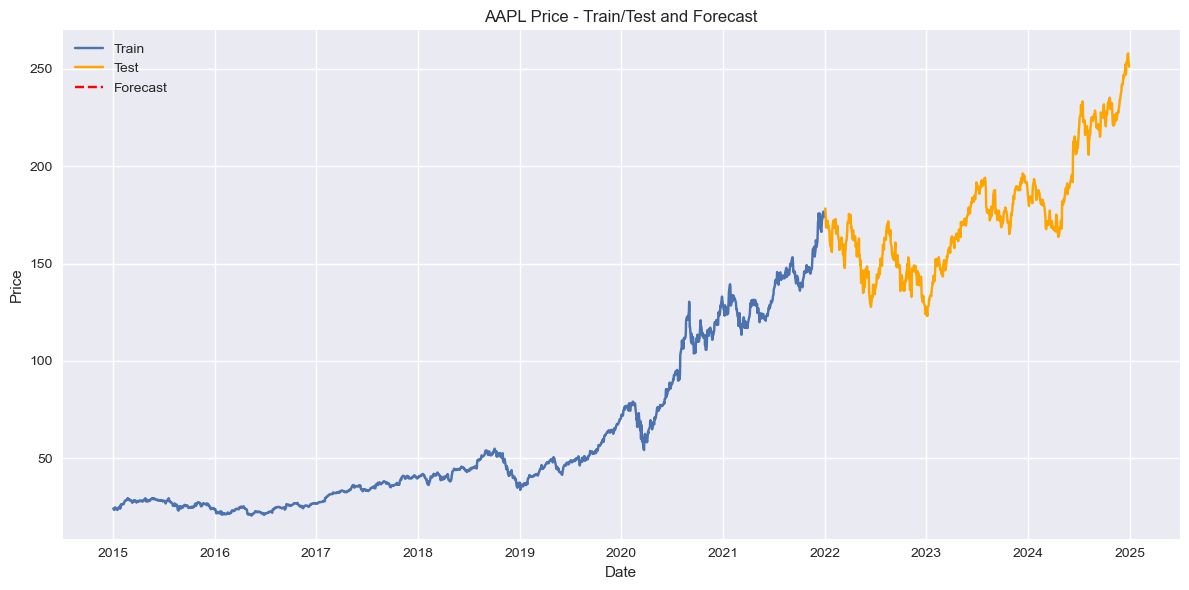

In [13]:
# ============================================================
# 6. Plot actual vs forecast
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test', color='orange')
plt.plot(forecast, label='Forecast', color='red', linestyle='--')
plt.title(f"{ticker} Price - Train/Test and Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# ============================================================
# 7. Extra analytics: returns & moving averages
# ============================================================

data['Return'] = data['Price'].pct_change()
data['MA30']   = data['Price'].rolling(window=30).mean()
data['MA90']   = data['Price'].rolling(window=90).mean()

print(data[['Price', 'Return', 'MA30', 'MA90']].head(15))


Price           Price    Return MA30 MA90
Ticker           AAPL                    
Date                                     
2015-01-02  24.237555       NaN  NaN  NaN
2015-01-05  23.554739 -0.028172  NaN  NaN
2015-01-06  23.556957  0.000094  NaN  NaN
2015-01-07  23.887274  0.014022  NaN  NaN
2015-01-08  24.805086  0.038423  NaN  NaN
2015-01-09  24.831684  0.001072  NaN  NaN
2015-01-12  24.219814 -0.024641  NaN  NaN
2015-01-13  24.434858  0.008879  NaN  NaN
2015-01-14  24.341751 -0.003810  NaN  NaN
2015-01-15  23.681101 -0.027141  NaN  NaN
2015-01-16  23.497105 -0.007770  NaN  NaN
2015-01-20  24.102316  0.025757  NaN  NaN
2015-01-21  24.286331  0.007635  NaN  NaN
2015-01-22  24.918142  0.026015  NaN  NaN
2015-01-23  25.046722  0.005160  NaN  NaN


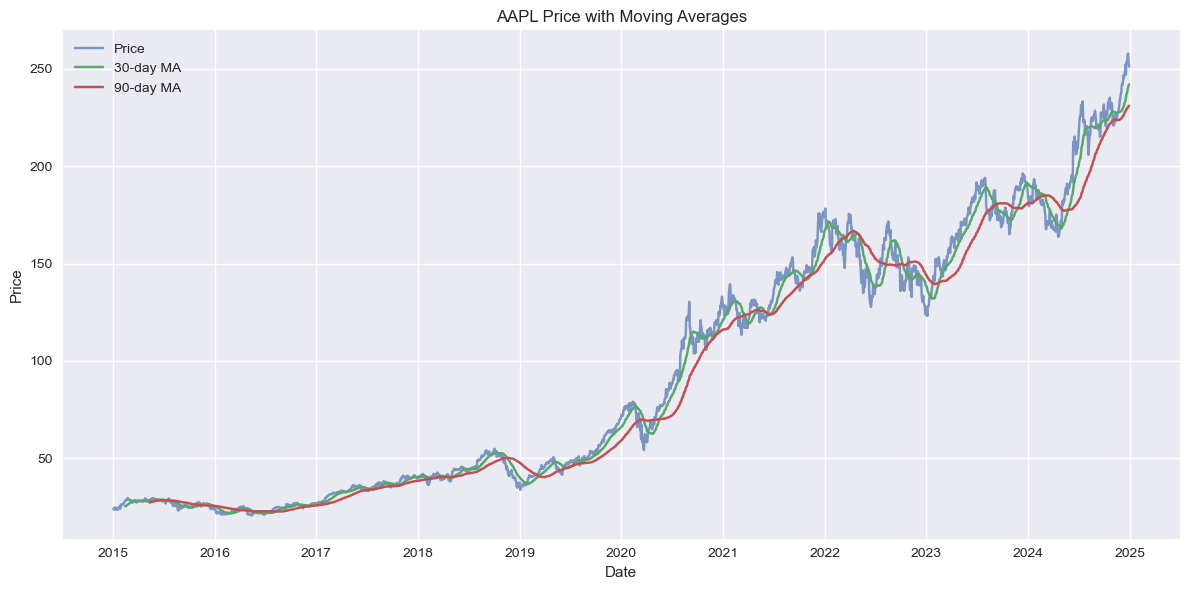

In [17]:
# Plot price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Price', alpha=0.7)
plt.plot(data['MA30'], label='30-day MA')
plt.plot(data['MA90'], label='90-day MA')
plt.title(f"{ticker} Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusions

The analysis demonstrates how to download and explore historical stock price data using `yfinance`, compute returns and moving averages, and build a simple forecasting model using exponential smoothing.
The forecasting performance can be improved by experimenting with more sophisticated time‑series models (such as ARIMA or Prophet) and by including additional predictors (e.g., macroeconomic indicators, technical indicators).
Always remember that financial markets are influenced by many factors; past performance does not guarantee future results.